# Assigment

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt

# Step 1: Loading and formatting the data

In [3]:
# I substract 1 because the indices in the file are 1-based
with open('./devkit_object/mapping/train_rand.txt', 'r') as f:
    train_rand_indices = [int(x) - 1 for x in f.read().split(',')]

val = pd.read_csv('./ImageSets/val.txt', header=None, names=['index'])
train = pd.read_csv('./ImageSets/train.txt', header=None, names=['index'])
train_mapping = pd.read_csv('./devkit_object/mapping/train_mapping.txt', header=None, names=['date', 'drive', 'frame'], sep=' ')
train_mapping['drive_number'] = train_mapping['drive'].str.extract(r'drive_(\d+)_sync')


train_rand_mapping = train_mapping.iloc[train_rand_indices].reset_index(drop=True)

# Check that the indices are correct
print("Train index 0")
print(train_rand_mapping.iloc[train.iloc[0].values[0] ])
print("Train index 1")
print(train_rand_mapping.iloc[train.iloc[1].values[0] ])

print("Val index 0")
print(train_rand_mapping.iloc[val.iloc[0].values[0] ])
print("Val index 1")
print(train_rand_mapping.iloc[val.iloc[1].values[0] ])



Train index 0
date                            2011_09_28
drive           2011_09_28_drive_0106_sync
frame                                   48
drive_number                          0106
Name: 0, dtype: object
Train index 1
date                            2011_09_26
drive           2011_09_26_drive_0046_sync
frame                                    6
drive_number                          0046
Name: 3, dtype: object
Val index 0
date                            2011_09_26
drive           2011_09_26_drive_0101_sync
frame                                  528
drive_number                          0101
Name: 1, dtype: object
Val index 1
date                            2011_09_26
drive           2011_09_26_drive_0086_sync
frame                                  108
drive_number                          0086
Name: 2, dtype: object


## Print variables

In [4]:
print("train_mapping")
print(train_mapping.head())
print("train_rand_mapping")
print(train_rand_mapping.head())
print("train")
print(train.head())
print("val")
print(val.head())

train_mapping
         date                       drive  frame drive_number
0  2011_09_26  2011_09_26_drive_0005_sync    109         0005
1  2011_09_26  2011_09_26_drive_0005_sync    125         0005
2  2011_09_26  2011_09_26_drive_0005_sync    127         0005
3  2011_09_26  2011_09_26_drive_0005_sync    130         0005
4  2011_09_26  2011_09_26_drive_0005_sync    133         0005
train_rand_mapping
         date                       drive  frame drive_number
0  2011_09_28  2011_09_28_drive_0106_sync     48         0106
1  2011_09_26  2011_09_26_drive_0101_sync    528         0101
2  2011_09_26  2011_09_26_drive_0086_sync    108         0086
3  2011_09_26  2011_09_26_drive_0046_sync      6         0046
4  2011_09_26  2011_09_26_drive_0101_sync    765         0101
train
   index
0      0
1      3
2      7
3      9
4     10
val
   index
0      1
1      2
2      4
3      5
4      6


## Step 2: Checking if train and val sets contain separate video sequences

In [5]:
def check_train_val_sets(train, val, train_rand_mapping):
    train_date_drive_pairs = train_rand_mapping.iloc[train['index'].values][['date', 'drive_number']].drop_duplicates()

    # print(train_date_drive_pairs.head())
    # Extract unique date and drive number pairs from val set
    val_date_drive_pairs = train_rand_mapping.iloc[val['index'].values][['date', 'drive_number']].drop_duplicates()
    # print(val_date_drive_pairs.head())
    # Check if any date and drive number pairs are common between train and val sets
    common_date_drive_pairs = train_date_drive_pairs.merge(val_date_drive_pairs, on=['date', 'drive_number'])

    if common_date_drive_pairs.empty:
        print("The train and val sets contain different video sequences.")
    else:
        print("The train and val sets have some common video sequences:")
        print(common_date_drive_pairs)

In [6]:
check_train_val_sets(train, val, train_rand_mapping)

The train and val sets contain different video sequences.


## Step 3: Create a new train and val sets from prior test set. 

In [7]:
test_new = val

# Shuffle the unique date and drive pairs in the train set + reset the index
train_shuffled = train.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate the split point
size_of_train = 3340
size_of_val = 372

# Create a dictionary to group the train_rand_mapping from train_shuffled by video sequence
grouped_by_video = {}
for i, row in train_shuffled.iterrows():
    date = train_rand_mapping.iloc[row['index']]['date']
    drive_number = train_rand_mapping.iloc[row['index']]['drive_number']
    video_sequence = (date, drive_number)
    if video_sequence not in grouped_by_video:
        grouped_by_video[video_sequence] = []
    grouped_by_video[video_sequence].append(row['index'])

# Shuffle the video sequences
video_sequences = list(grouped_by_video.keys())
random.shuffle(video_sequences)

selected_video_sequences = {}
current_size = 0

for video_sequence in video_sequences:
    indices = grouped_by_video[video_sequence]
    
    if current_size + len(indices) == size_of_val:
        selected_video_sequences[video_sequence] = indices
        current_size += len(indices)
        break
    
    if current_size + len(indices) < size_of_val:
        selected_video_sequences[video_sequence] = indices
        current_size += len(indices)


# Remove selected video sequences from the grouped_by_video dictionary
for video_sequence in selected_video_sequences:
    grouped_by_video.pop(video_sequence)


# Create a new train set
train_new = pd.DataFrame(columns=['index'])
for video_sequence in grouped_by_video:
    for index in grouped_by_video[video_sequence]:
        train_new = train_new.append({'index': index}, ignore_index=True)

# Create a new val set
val_new = pd.DataFrame(columns=['index'])
for video_sequence in selected_video_sequences:
    for index in selected_video_sequences[video_sequence]:
        val_new = val_new.append({'index': index}, ignore_index=True)

# Sort the indices in the new train and val sets
train_new = train_new.sort_values(by=['index']).reset_index(drop=True)
val_new = val_new.sort_values(by=['index']).reset_index(drop=True)

check_train_val_sets(train_new, val_new, train_rand_mapping)

print("train_new")
print(train_new.head())
print("Size of train_new: {}".format(len(train_new)))
print("val_new")
print(val_new.head())
print("Size of val_new: {}".format(len(val_new)))
print("test_new")
print(test_new.head())
print("Size of test_new: {}".format(len(test_new)))



The train and val sets contain different video sequences.
train_new
  index
0     0
1     3
2     7
3     9
4    10
Size of train_new: 3340
val_new
  index
0    34
1    41
2    69
3    74
4    82
Size of val_new: 372
test_new
   index
0      1
1      2
2      4
3      5
4      6
Size of test_new: 3769


## Save new sets

In [11]:
# saving values with padding 0 to 6 digits
train_new['index'] = train_new['index'].apply(lambda x: str(x).zfill(6))
val_new['index'] = val_new['index'].apply(lambda x: str(x).zfill(6))
test_new['index'] = test_new['index'].apply(lambda x: str(x).zfill(6))

# Save the new train, val and test sets as txt files in the new ImageSets folder 
train_new.to_csv('./Mateusz_ImageSets/train_new.txt', header=False, index=False)
val_new.to_csv('./Mateusz_ImageSets/val_new.txt', header=False, index=False)
test_new.to_csv('./Mateusz_ImageSets/test_new.txt', header=False, index=False)

# Additional step: plot distribution of new sets

In [9]:
def plot_distribution(train_set, val_set):
    train_sequence_lengths = [len(indices) for indices in train_set.values()]
    val_sequence_lengths = [len(indices) for indices in val_set.values()]
    
    plt.figure(figsize=(12, 6))
    plt.hist(train_sequence_lengths, bins=20, alpha=0.5, label='Train set')
    plt.hist(val_sequence_lengths, bins=20, alpha=0.5, label='Validation set')
    plt.xlabel('Number of frames per video sequence')
    plt.ylabel('Frequency')
    plt.title('Distribution of video sequences in train and validation sets')
    plt.legend(loc='upper right')
    plt.show()

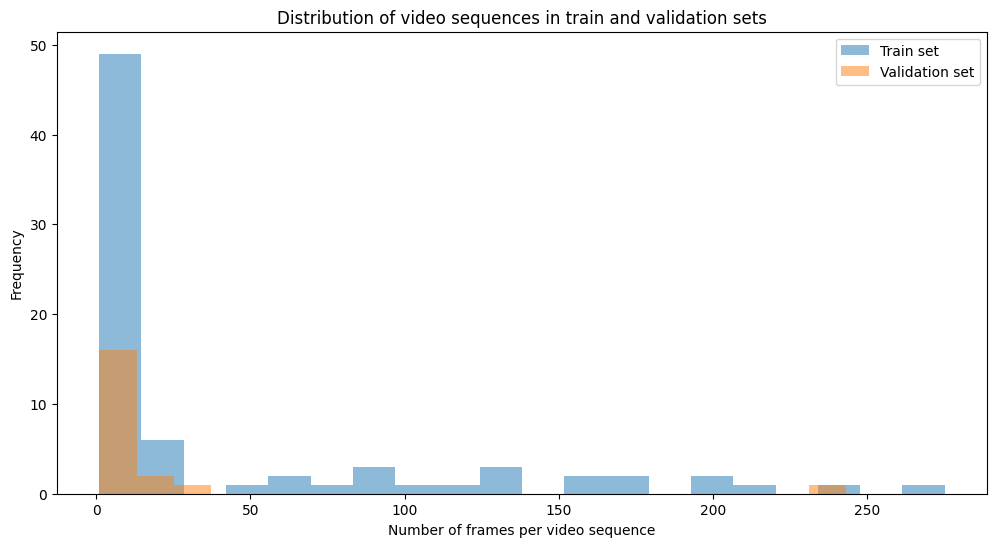

In [10]:
plot_distribution(grouped_by_video, selected_video_sequences)

# Requested intermediate step

In [12]:
unique_date_drive_pairs = train_rand_mapping[['date', 'drive_number']].drop_duplicates()
all_sequences_names = [f"{row['date']}_drive_{row['drive_number']}_sync" for _, row in unique_date_drive_pairs.iterrows()]

print("All video sequences:")
print(all_sequences_names)
print("Number of video sequences: {}".format(len(all_sequences_names)))

train_date_drive_pairs = train_rand_mapping.iloc[train_new['index'].values][['date', 'drive_number']].drop_duplicates()
val_date_drive_pairs = train_rand_mapping.iloc[val_new['index'].values][['date', 'drive_number']].drop_duplicates()
test_date_drive_pairs = train_rand_mapping.iloc[test_new['index'].values][['date', 'drive_number']].drop_duplicates()

train_sequences_names = [f"{row['date']}_{row['drive_number']}_sync" for _, row in train_date_drive_pairs.iterrows()]
val_sequences_names = [f"{row['date']}_{row['drive_number']}_sync" for _, row in val_date_drive_pairs.iterrows()]
test_sequences_names = [f"{row['date']}_{row['drive_number']}_sync" for _, row in test_date_drive_pairs.iterrows()]

print("\nVideo sequences in the train set (train_new):")
print(train_sequences_names)
print("Number of video sequences: {}".format(len(train_sequences_names)))
print("\nVideo sequences in the validation set (val_new):")
print(val_sequences_names)
print("Number of video sequences: {}".format(len(val_sequences_names)))
print("\nVideo sequences in the test set (test_new):")
print(test_sequences_names)
print("Number of video sequences: {}".format(len(test_sequences_names)))

All video sequences:
['2011_09_28_drive_0106_sync', '2011_09_26_drive_0101_sync', '2011_09_26_drive_0086_sync', '2011_09_26_drive_0046_sync', '2011_09_26_drive_0070_sync', '2011_09_29_drive_0026_sync', '2011_09_26_drive_0056_sync', '2011_09_26_drive_0064_sync', '2011_09_26_drive_0036_sync', '2011_09_26_drive_0106_sync', '2011_09_26_drive_0018_sync', '2011_09_26_drive_0027_sync', '2011_09_26_drive_0028_sync', '2011_09_29_drive_0071_sync', '2011_09_26_drive_0051_sync', '2011_09_26_drive_0022_sync', '2011_09_26_drive_0095_sync', '2011_09_26_drive_0019_sync', '2011_10_03_drive_0047_sync', '2011_09_26_drive_0061_sync', '2011_09_26_drive_0032_sync', '2011_09_28_drive_0177_sync', '2011_09_26_drive_0087_sync', '2011_09_26_drive_0035_sync', '2011_09_26_drive_0096_sync', '2011_09_26_drive_0014_sync', '2011_09_26_drive_0057_sync', '2011_09_26_drive_0059_sync', '2011_09_26_drive_0039_sync', '2011_09_26_drive_0091_sync', '2011_09_26_drive_0001_sync', '2011_09_26_drive_0084_sync', '2011_09_26_drive_

# Testing new sets

In [13]:
# I substract 1 because the indices in the file are 1-based
with open('./devkit_object/mapping/train_rand.txt', 'r') as f:
    train_rand_indices = [int(x) - 1 for x in f.read().split(',')]

val = pd.read_csv('./Mateusz_ImageSets/val_new.txt', header=None, names=['index'])
train = pd.read_csv('./Mateusz_ImageSets/train_new.txt', header=None, names=['index'])
test = pd.read_csv('./Mateusz_ImageSets/test_new.txt', header=None, names=['index'])
train_mapping = pd.read_csv('./devkit_object/mapping/train_mapping.txt', header=None, names=['date', 'drive', 'frame'], sep=' ')
train_mapping['drive_number'] = train_mapping['drive'].str.extract(r'drive_(\d+)_sync')


train_rand_mapping = train_mapping.iloc[train_rand_indices].reset_index(drop=True)

# Check that the indices are correct
# print("Train index 0")
# print(train_rand_mapping.iloc[train.iloc[0].values[0] ])
# print("Train index 1")
# print(train_rand_mapping.iloc[train.iloc[1].values[0] ])

# print("Val index 0")
# print(train_rand_mapping.iloc[val.iloc[0].values[0] ])
# print("Val index 1")
# print(train_rand_mapping.iloc[val.iloc[1].values[0] ])

print("Test index 0")
print(train_rand_mapping.iloc[test.iloc[0].values[0] ])
print("Test index 1")
print(train_rand_mapping.iloc[test.iloc[1].values[0] ])

check_train_val_sets(train, val, train_rand_mapping)
check_train_val_sets(train, test, train_rand_mapping)
check_train_val_sets(val, test, train_rand_mapping)


Test index 0
date                            2011_09_26
drive           2011_09_26_drive_0101_sync
frame                                  528
drive_number                          0101
Name: 1, dtype: object
Test index 1
date                            2011_09_26
drive           2011_09_26_drive_0086_sync
frame                                  108
drive_number                          0086
Name: 2, dtype: object
The train and val sets contain different video sequences.
The train and val sets contain different video sequences.
The train and val sets contain different video sequences.
